In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.utils import make_grid

import math
import random

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image , ImageOps, ImageEnhance


In [2]:

num_epochs = 5
batch_size = 300



In [3]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, file_path, 
                 transform_train =transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ]),
                 transform_test = transforms.Compose([
                     transforms.ToPILImage(),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ])
                ):
        
        df = pd.read_csv(file_path)
        
        if len(df.columns) == 784:
            # test data
            self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
            
        self.transform_train = transform_train
        self.transform_test = transform_test
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is None:
            return self.transform_test(self.X[idx])
        else:
            return self.transform_train(self.X[idx]) , self.y[idx]       

In [4]:
device = torch.device('cuda')
device

device(type='cuda')

In [5]:
train_dataset = MNIST_data('fashion-mnist_train.csv',transform_train =transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ]),
                 transform_test = transforms.Compose([
                     transforms.ToPILImage(),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ])
                )
test_dataset = MNIST_data('fashion-mnist_test.csv',transform_train =transforms.Compose([
                           transforms.ToPILImage(),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ]),
                 transform_test = transforms.Compose([
                     transforms.ToPILImage(),
                           transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5,), std=(0.5,))
                       ])
                )

In [6]:
train_loader =DataLoader(dataset = train_dataset, batch_size = batch_size,shuffle = True)
test_loader =DataLoader(dataset= test_dataset,batch_size = batch_size,shuffle=False)

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([300, 1, 32, 32])
torch.Size([300])


In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,kernel_size =3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(16,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
        
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*7*7,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace= True),
            nn.Linear(512,256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace= True),
            nn.Linear(256,10),
        
        )
    def forward(self,x):
        x = self.conv1(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x
    


In [9]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), #in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2), #kernel_size
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 384, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace = True)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x

In [30]:
model = AlexNet(10)
model.to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()
    
    for batch_idx , (data,target) in enumerate(train_loader):
        data,target = Variable(data),Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss  = criterion(output,target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))         

In [32]:
def evaluate(data_loader):
    model.eval()
    loss=0
    correct=0
    for data, target in data_loader:
        data, target = Variable(data),Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss+= F.cross_entropy(output,target,size_average=False).data
        
        pred = output.data.max(1,keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return loss ,  correct / len(data_loader.dataset)

In [33]:
loss_lis =[]
acc_lis = []
for epoch in range(10):
    train(epoch)
    loss , acc = evaluate(train_loader)
    loss_lis.append(loss)
    acc_lis.append(acc)
    

Train Epoch: 0 [30000/60000 (50%)]	Loss: 164.839722
Train Epoch: 0 [60000/60000 (100%)]	Loss: 116.222839

Average loss: 0.4474, Accuracy: 50121/60000 (83.535%)

Train Epoch: 1 [30000/60000 (50%)]	Loss: 142.406097
Train Epoch: 1 [60000/60000 (100%)]	Loss: 90.527596

Average loss: 0.3457, Accuracy: 52308/60000 (87.180%)

Train Epoch: 2 [30000/60000 (50%)]	Loss: 96.899162
Train Epoch: 2 [60000/60000 (100%)]	Loss: 91.823471

Average loss: 0.2988, Accuracy: 53569/60000 (89.282%)

Train Epoch: 3 [30000/60000 (50%)]	Loss: 111.833893
Train Epoch: 3 [60000/60000 (100%)]	Loss: 91.116043

Average loss: 0.2750, Accuracy: 54024/60000 (90.040%)

Train Epoch: 4 [30000/60000 (50%)]	Loss: 95.902229
Train Epoch: 4 [60000/60000 (100%)]	Loss: 75.375824

Average loss: 0.2520, Accuracy: 54287/60000 (90.478%)

Train Epoch: 5 [30000/60000 (50%)]	Loss: 87.229362
Train Epoch: 5 [60000/60000 (100%)]	Loss: 77.005058

Average loss: 0.2214, Accuracy: 55135/60000 (91.892%)

Train Epoch: 6 [30000/60000 (50%)]	Loss: 8

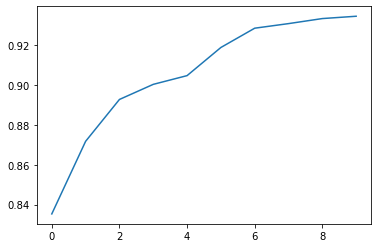

In [40]:
plt.plot(range(10),acc_lis)

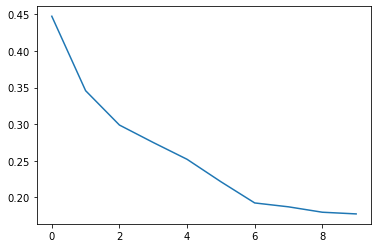

In [41]:
plt.plot(range(10),loss_lis)

In [42]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, (data,target) in enumerate(data_loader):
        data,target = Variable(data, volatile=True) , Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [43]:
test_pred = prediciton(test_loader)

C:\Users\Lenovo\anaconda3\envs\gpuenv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [44]:
test_csv = pd.read_csv('fashion-mnist_test.csv')
test_labels = torch.tensor(test_csv['label'])

In [45]:
test_labels

tensor([0, 1, 2,  ..., 8, 8, 1])

In [46]:
test_pred = test_pred.reshape((1,10000))
test_pred = test_pred.squeeze()
test_pred

tensor([0, 1, 2,  ..., 8, 8, 1])

In [47]:
evl = test_labels == test_pred

In [48]:
test_acc=0
for i in evl:
    if i:
        test_acc+=1
        
test_acc=(test_acc*10000)*100
test_acc

9232000000